# Exploratory Data Analysis

## Import packages

In [1]:
# import packages


%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from pathlib import Path

import pandas as pd
import numpy as np
from collections import Counter, defaultdict
import itertools
from time import time

import string
import spacy

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use("seaborn")
mpl.rcParams['legend.frameon'] = 'True'

import pyLDAvis
import pyLDAvis.sklearn

stop_mk = [w.replace('\n', '') for w in open(Path('../stopwords')/'stopwords_mk.txt').readlines()]
stop_sh = [w.replace('\n', '') for w in open(Path('../stopwords')/'stopwords_sh.txt').readlines()]

## Load all text files for a specific language from all the subdirectories

In [2]:
# load text files

def get_text(lang, folder_name):
  """
  input : language name
  output: list of sentences from the text files
  """
  lang = lang.lower()
  text = []
  for path in Path(f"../dataset/{folder_name}/").iterdir():
    if path.is_dir():
      for p in path.glob(f"**/{lang}.txt"):
        with open(p, "r") as f:
          lines = f.readlines()
        f.close()
        text.append(lines)

  text = list(itertools.chain(*text))
  text = [t.replace("\n", "") for t in text]

  return text

## Dataset Statistics

### Functions

#### Build a corpus of non-stopwords, stopwords, non-punctuations, and punctuations for a specific language
- for tokenization, we used the existing spacy language models for English and Macedonian
- to find the stopwords in [Macedonian](https://github.com/explosion/spaCy/blob/master/spacy/lang/sq/stop_words.py) and [Shqip](https://github.com/explosion/spaCy/blob/master/spacy/lang/mk/stop_words.py), we used their respective lists of stopwords provided in spacy

In [3]:
# build corpus


def build_corpus(text, lang, SHOW_COUNT=True):
  """
  input : list of sentences from the text files, language
  output: non-stopwords list, stopwords list,
          non-punctuation word list, and
          punctuation list
  """

  if lang == "English":
    nlp = spacy.load("en_core_web_lg")
    doc = nlp(" ".join(text))
  elif lang == "Macedonian":
    nlp = spacy.load("mk_core_news_lg")
    doc = nlp(" ".join(text))
    stop_words = stop_mk
  elif lang == "Shqip":
    doc = " ".join(text)
    stop_words = stop_sh

  # list of word tokens
  if lang == "Shqip":
    token_list = doc.lower().split()
  else:
    token_list = [token.text.lower() for token in doc]

  # loop for stopwords and non-stopwords
  non_stopwords, stopwords = [], []

  for word in token_list:
    if lang == "English":
      lexeme = nlp.vocab[word]
      if lexeme.is_stop == False:
        non_stopwords.append(word)
      else:
        stopwords.append(word)
    else:
      if word in stop_words:
        stopwords.append(word)
      else:
        non_stopwords.append(word)

  # remove punctuation
  non_punctuation = [
      "".join(w for w in word if w not in string.punctuation)
      for word in non_stopwords
  ]

  # remove white space
  non_punctuation = [
      word for word in non_punctuation if (word != "" and word != " ")
  ]

  # list of punctuations
  punctuation = [
      word for word in non_stopwords if word in string.punctuation
  ]

  if SHOW_COUNT:
    print(f"Total Number of Sentences                  : {len(text)}")
    print(
        f"Total Number of Words                        : {len(non_stopwords)}"
    )
    print(
        f"Total Number of Stopwords                    : {len(stopwords)}")
    print(
        f"Total Number of Unique Words                 : {len(np.unique(non_stopwords))}"
    )
    print(
        f"Total Number of Unique Stopwords             : {len(np.unique(stopwords))}"
    )
    print(
        f"Total Number of Words (no punctuation)       : {len(non_punctuation)}"
    )
    print(
        f"Total Number of Punctuation                  : {len(punctuation)}"
    )
    print(
        f"Total Number of Unique Words (no punctuation): {len(np.unique(non_punctuation))}"
    )
    print(
        f"Total Number of Unique Punctuation           : {len(np.unique(punctuation))}"
    )

  return non_stopwords, stopwords, non_punctuation, punctuation

#### Find N most-frequent non-punctuation non-stopwords, stopwords, bigrams, and trigrams for a specific language

In [4]:
# word/bigram/trigram frequency


def word_frequency(non_punctuation, stopwords, top_n, SHOW_FREQ=True):
  """
  input : non-punctuation non-stopwords, stopwords
  output: top N non-punctuation non-stopwords frequency, 
          top N stopwords freqency
  """
  topn_freq_word = dict(Counter(non_punctuation).most_common(top_n))
  topn_freq_stop = dict(Counter(stopwords).most_common(top_n))

  if SHOW_FREQ:
    print(f"Top {top_n} Most Frequent Words     : {topn_freq_word}")
    print(f"Top {top_n} Most Frequent Stopwords : {topn_freq_stop}")

  return topn_freq_word, topn_freq_stop


def ngram_frequency(text,
                    n=None,
                    top_n=None,
                    SHOW_FREQ=True,
                    WHICH_GRAM="Bigrams"):
  """
  input : list of sentences from the text files
  output: top N bigrams/trigrams
  """
  vec = CountVectorizer(ngram_range=(n, n)).fit(text)
  bag_of_words = vec.transform(text)
  sum_words = bag_of_words.sum(axis=0)
  ngram_freq = [(word, sum_words[0, idx])
                for word, idx in vec.vocabulary_.items()]
  ngram_freq = sorted(ngram_freq, key=lambda x: x[1], reverse=True)
  ngram_freq = dict(ngram_freq[:top_n])

  if SHOW_FREQ:
    print(f"Top {top_n} Most Frequent {WHICH_GRAM} : {ngram_freq}")

  return ngram_freq

#### Calculate length of sentence, word count per sentence, average word length per sentence for a specific language

In [5]:
# statistics on words and sentences


def word_sentence_statistics(text, lang):
  """
  input : list of sentences from the text files
  output: length of sentence, 
          word count per sentence,
          average word length per sentence
  """
  if lang == "English":
    nlp = spacy.load("en_core_web_lg")
  elif lang == "Macedonian":
    nlp = spacy.load("mk_core_news_lg")

  sent_len = [len(t) for t in text]

  if lang == "Shqip":
    word_count = [len(t.lower().split()) for t in text]
    avg_word_len = [
        np.mean([len(token) for token in t.lower().split()]) for t in text
    ]
  else:
    word_count = [
        len([token.text.lower() for token in nlp(t)]) for t in text
    ]
    avg_word_len = [
        np.mean([len(token.text.lower()) for token in nlp(t)])
        for t in text
    ]

  return sent_len, word_count, avg_word_len


def word_sentence_statistics_all(lang_list, folder_name):
  """
  input : list of all the language names
  output: a dataframe with length of sentence, word count per sentence,
          and average word length per sentence for all languages
  """

  text_list = [get_text(lang, folder_name) for lang in lang_list]

  sent_len_list, word_count_list, avg_word_len_list = [], [], []
  df = pd.DataFrame()
  for i in range(len(lang_list)):
    sent_len, word_count, avg_word_len = word_sentence_statistics(
        text_list[i], lang_list[i])
    sent_len_list.append(sent_len)
    word_count_list.append(word_count)
    avg_word_len_list.append(avg_word_len)

  lang = [[lang_list[i]] * len(text_list[i]) for i in range(len(lang_list))]

  df["language"] = list(itertools.chain(*lang))
  df["text"] = list(itertools.chain(*text_list))
  df["sentence_length"] = list(itertools.chain(*sent_len_list))
  df["word_count_per_sentence"] = list(itertools.chain(*word_count_list))
  df["mean_wlength_per_sentence"] = list(itertools.chain(*avg_word_len_list))

  return df

#### Utilities for barplot, histplot, violinplot and boxplot

In [6]:
# plot utils


def bar_hist_plot(x,
                  y,
                  SNS=True,
                  BAR_PLOT=True,
                  color="b",
                  alpha=1,
                  figsize=(8, 6),
                  xlabel="",
                  ylabel="",
                  title="",
                  fontsize=15):

  plt.figure(figsize=figsize)

  if BAR_PLOT:
    if SNS:
      sns.barplot(x=y, y=x)
    else:
      plt.barh(x[::-1], y[::-1], color=color, alpha=alpha)
  else:
    if SNS:
      sns.distplot(
          x,
          color=color,
          hist=True,
          kde=True,
          norm_hist=True,
          kde_kws={
              'linewidth': 3
          })
    else:
      plt.hist(x, color=color, alpha=alpha, density=True)

  plt.xticks(size=fontsize - 1)
  plt.yticks(size=fontsize - 1)
  plt.xlabel(xlabel, size=fontsize)
  plt.ylabel(ylabel, size=fontsize)
  plt.title(title, size=fontsize)
  plt.show()


def plot_stat_all(df,
                  column_name,
                  ylabel,
                  figsize=(7, 6),
                  fontsize=15,
                  BOX_PLOT=False):
  """
  input : a dataframe with length of sentence, word count per sentence,
          and average word length per sentence for all languages
  output: violin
  """

  plt.figure(figsize=figsize)
  if BOX_PLOT:
    sns.boxplot(
        x="language",
        y=column_name,
        data=df,
        palette="muted",
    )
  else:
    sns.violinplot(
        x="language",
        y=column_name,
        data=df,
        palette="muted",
        inner="quartile",
    )

  plt.xticks(size=fontsize - 1)
  plt.yticks(size=fontsize - 1)
  plt.xlabel("Language", size=fontsize)
  plt.ylabel(ylabel, size=fontsize)
  plt.title(f"{ylabel} in the documents", size=fontsize)
  plt.show()

### Results

#### Define params

In [7]:
# define params

lang_en  = "English"
lang_sh  = "Shqip"
lang_mk  = "Macedonian"
top_n = 20
folder_name = "english-macedonian-shqip"

#### Sentence count, word count, stopwords, non-stopwords, punctuations, ngrams

###### English

Total Number of Sentences                  : 5843
Total Number of Words                        : 98150
Total Number of Stopwords                    : 62304
Total Number of Unique Words                 : 6966
Total Number of Unique Stopwords             : 260
Total Number of Words (no punctuation)       : 78210
Total Number of Punctuation                  : 15699
Total Number of Unique Words (no punctuation): 6877
Total Number of Unique Punctuation           : 14


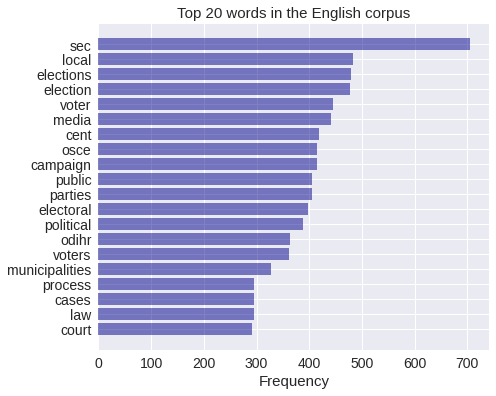

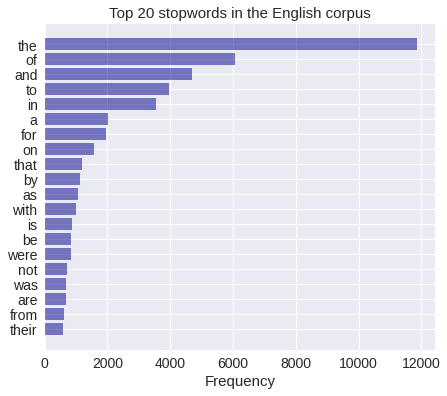

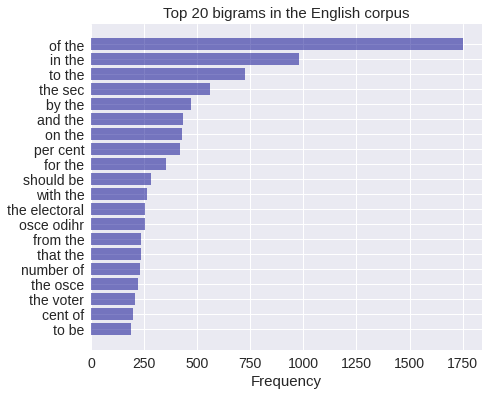

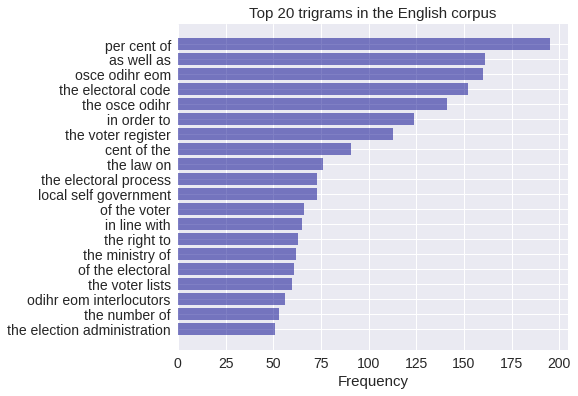

In [8]:
# English documents

text_en = get_text(lang_en, folder_name)
non_stop_en, stop_en, non_punc_en, punc_en = build_corpus(text_en, lang_en)
topn_word_en, topn_stop_en = word_frequency(non_punc_en, stop_en, top_n, SHOW_FREQ=False)
topn_bigrams_en = ngram_frequency(text_en, n=2, top_n=top_n, WHICH_GRAM="Bigrams", SHOW_FREQ=False)
topn_trigrams_en = ngram_frequency(text_en, n=3, top_n=top_n, WHICH_GRAM="Trigrams", SHOW_FREQ=False)

bar_hist_plot(list(topn_word_en.keys()),
              list(topn_word_en.values()),
              SNS=False, BAR_PLOT=True,
              color="darkblue", alpha=0.5,
              figsize=(7,6),
              xlabel="Frequency", ylabel="",
              title=f"Top 20 words in the {lang_en} corpus",
              fontsize=15)

bar_hist_plot(list(topn_stop_en.keys()),
              list(topn_stop_en.values()), 
              SNS=False, BAR_PLOT=True,
              color="darkblue", alpha=0.5,
              figsize=(7,6),
              xlabel="Frequency", ylabel="",
              title=f"Top 20 stopwords in the {lang_en} corpus",
              fontsize=15)


bar_hist_plot(list(topn_bigrams_en.keys()),
              list(topn_bigrams_en.values()), 
              SNS=False, BAR_PLOT=True,
              color="darkblue", alpha=0.5,
              figsize=(7,6),
              xlabel="Frequency", ylabel="",
              title=f"Top 20 bigrams in the {lang_en} corpus",
              fontsize=15)

bar_hist_plot(list(topn_trigrams_en.keys()),
              list(topn_trigrams_en.values()), 
              SNS=False, BAR_PLOT=True,
              color="darkblue", alpha=0.5,
              figsize=(7,6),
              xlabel="Frequency", ylabel="",
              title=f"Top 20 trigrams in the {lang_en} corpus",
              fontsize=15)

###### Macedonian

Total Number of Sentences                  : 5843
Total Number of Words                        : 105666
Total Number of Stopwords                    : 60652
Total Number of Unique Words                 : 12641
Total Number of Unique Stopwords             : 334
Total Number of Words (no punctuation)       : 82913
Total Number of Punctuation                  : 15242
Total Number of Unique Words (no punctuation): 12530
Total Number of Unique Punctuation           : 17


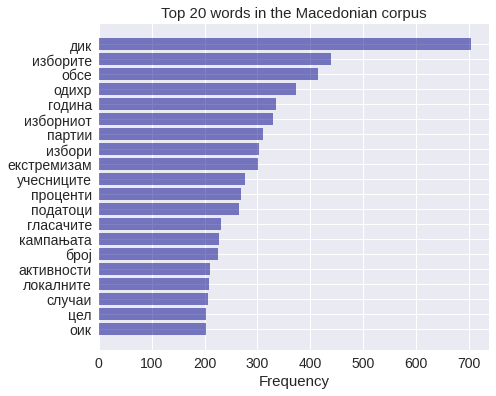

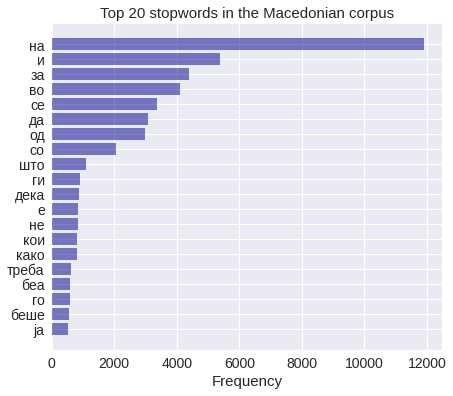

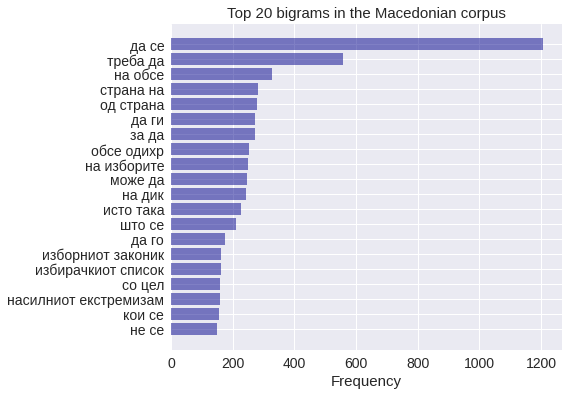

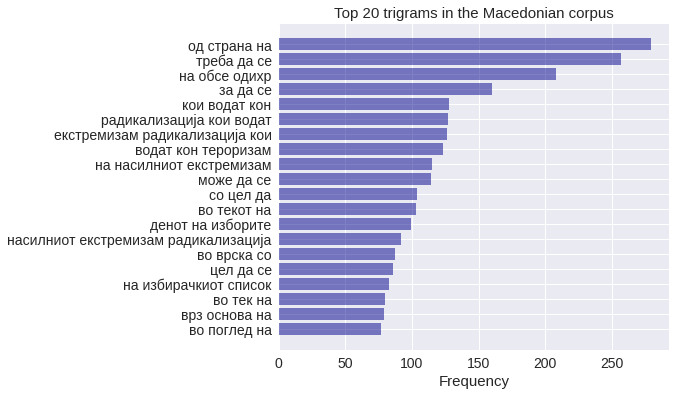

In [9]:
# Macedonian documents

text_mk = get_text(lang_mk, folder_name)
non_stop_mk, stop_mk, non_punc_mk, punc_mk = build_corpus(text_mk, lang_mk)
topn_word_mk, topn_stop_mk = word_frequency(non_punc_mk, stop_mk, top_n, SHOW_FREQ=False)
topn_bigrams_mk = ngram_frequency(text_mk, n=2, top_n=top_n, WHICH_GRAM="Bigrams", SHOW_FREQ=False)
topn_trigrams_mk = ngram_frequency(text_mk, n=3, top_n=top_n, WHICH_GRAM="Trigrams", SHOW_FREQ=False)

bar_hist_plot(list(topn_word_mk.keys()),
              list(topn_word_mk.values()),
              SNS=False, BAR_PLOT=True,
              color="darkblue", alpha=0.5,
              figsize=(7,6),
              xlabel="Frequency", ylabel="",
              title=f"Top 20 words in the {lang_mk} corpus",
              fontsize=15)

bar_hist_plot(list(topn_stop_mk.keys()),
              list(topn_stop_mk.values()), 
              SNS=False, BAR_PLOT=True,
              color="darkblue", alpha=0.5,
              figsize=(7,6),
              xlabel="Frequency", ylabel="",
              title=f"Top 20 stopwords in the {lang_mk} corpus",
              fontsize=15)

bar_hist_plot(list(topn_bigrams_mk.keys()),
              list(topn_bigrams_mk.values()), 
              SNS=False, BAR_PLOT=True,
              color="darkblue", alpha=0.5,
              figsize=(7,6),
              xlabel="Frequency", ylabel="",
              title=f"Top 20 bigrams in the {lang_mk} corpus",
              fontsize=15)

bar_hist_plot(list(topn_trigrams_mk.keys()),
              list(topn_trigrams_mk.values()), 
              SNS=False, BAR_PLOT=True,
              color="darkblue", alpha=0.5,
              figsize=(7,6),
              xlabel="Frequency", ylabel="",
              title=f"Top 20 trigrams in the {lang_mk} corpus",
              fontsize=15)

###### Shqip

Total Number of Sentences                  : 5843
Total Number of Words                        : 119774
Total Number of Stopwords                    : 35307
Total Number of Unique Words                 : 15673
Total Number of Unique Stopwords             : 129
Total Number of Words (no punctuation)       : 119704
Total Number of Punctuation                  : 67
Total Number of Unique Words (no punctuation): 11666
Total Number of Unique Punctuation           : 5


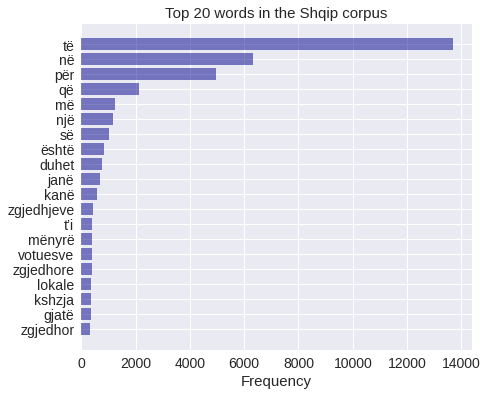

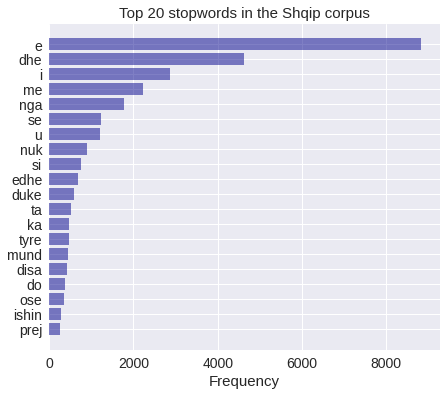

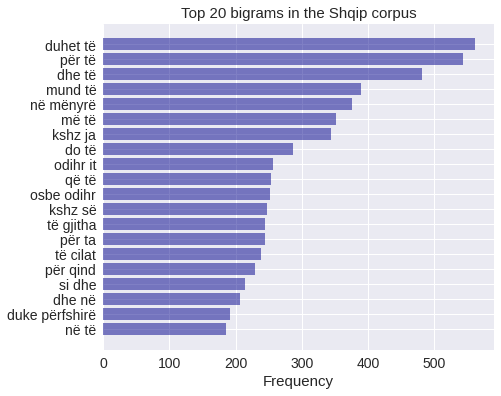

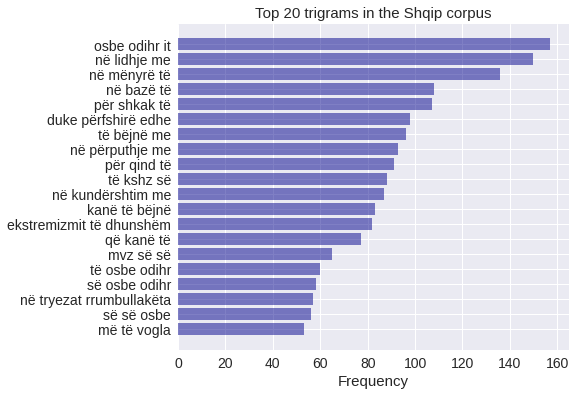

In [10]:
# Shqip documents

text_sh = get_text(lang_sh, folder_name)
non_stop_sh, stop_sh, non_punc_sh, punc_sh = build_corpus(text_sh, lang_sh)
topn_word_sh, topn_stop_sh = word_frequency(non_punc_sh, stop_sh, top_n, SHOW_FREQ=False)
topn_bigrams_sh = ngram_frequency(text_sh, n=2, top_n=top_n, WHICH_GRAM="Bigrams", SHOW_FREQ=False)
topn_trigrams_sh = ngram_frequency(text_sh, n=3, top_n=top_n, WHICH_GRAM="Trigrams", SHOW_FREQ=False)

bar_hist_plot(list(topn_word_sh.keys()),
              list(topn_word_sh.values()),
              SNS=False, BAR_PLOT=True,
              color="darkblue", alpha=0.5,
              figsize=(7,6),
              xlabel="Frequency", ylabel="",
              title=f"Top 20 words in the {lang_sh} corpus",
              fontsize=15)

bar_hist_plot(list(topn_stop_sh.keys()),
              list(topn_stop_sh.values()), 
              SNS=False, BAR_PLOT=True,
              color="darkblue", alpha=0.5,
              figsize=(7,6),
              xlabel="Frequency", ylabel="",
              title=f"Top 20 stopwords in the {lang_sh} corpus",
              fontsize=15)

bar_hist_plot(list(topn_bigrams_sh.keys()),
              list(topn_bigrams_sh.values()), 
              SNS=False, BAR_PLOT=True,
              color="darkblue", alpha=0.5,
              figsize=(7,6),
              xlabel="Frequency", ylabel="",
              title=f"Top 20 bigrams in the {lang_sh} corpus",
              fontsize=15)

bar_hist_plot(list(topn_trigrams_sh.keys()),
              list(topn_trigrams_sh.values()), 
              SNS=False, BAR_PLOT=True,
              color="darkblue", alpha=0.5,
              figsize=(7,6),
              xlabel="Frequency", ylabel="",
              title=f"Top 20 trigrams in the {lang_sh} corpus",
              fontsize=15)

#### Sentence length, word count per sentence, average word length per sentence

/net/kdinxidk03/opt/NFS/75y/anaconda3/envs/rose/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/net/kdinxidk03/opt/NFS/75y/anaconda3/envs/rose/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


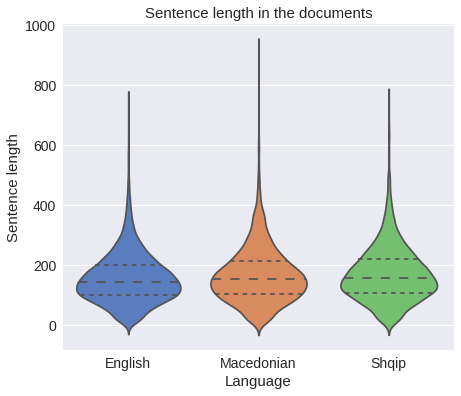

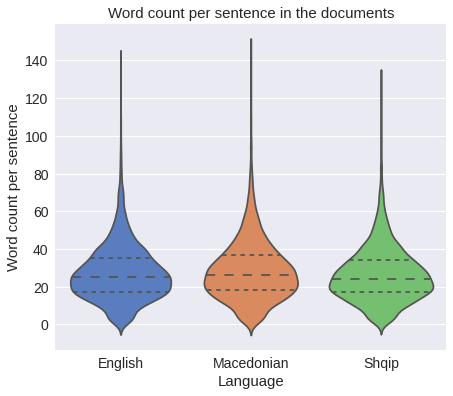

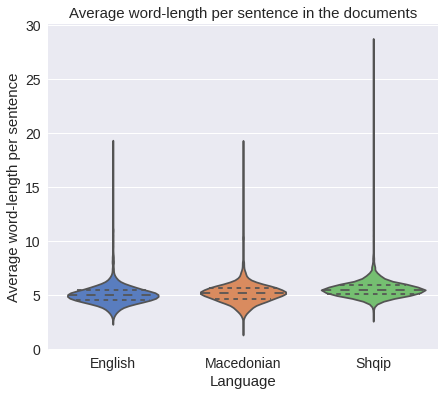

In [11]:
# violinplot for all parallel languages

assert len(text_en)==len(text_mk)==len(text_sh)

lang_list = [lang_en, lang_mk, lang_sh]

df = word_sentence_statistics_all(lang_list, folder_name)

plot_stat_all(df, "sentence_length", "Sentence length", 
                  figsize = (7,6), fontsize=15, BOX_PLOT=False
                 )

plot_stat_all(df, "word_count_per_sentence", "Word count per sentence", 
                  figsize = (7,6), fontsize=15, BOX_PLOT=False
                 )

plot_stat_all(df, "mean_wlength_per_sentence", "Average word-length per sentence", 
                  figsize = (7,6), fontsize=15, BOX_PLOT=False
                 )

## Topic modeling

### Functions

In [17]:
def lda_preprocess(text, lang, n_features):
  """
  input : list of sentences from the text file, language
  output: vectorizer, vector repr. of the texts,
          features extracted from the vectorizer
  """

  if lang == "English":
    nlp = spacy.load("en_core_web_lg")
  elif lang == "Macedonian":
    nlp = spacy.load("mk_core_news_lg")
    stop_words = stop_mk
  else:
    stop_words = stop_sh

  nostop_text = []
  for sent in text:
    nostop_sentence = []
    if lang == "English":
      doc = nlp(sent)
      for word in doc:
        word = word.text.lower()
        lexeme = nlp.vocab[word]
        if lexeme.is_stop == False:
          nostop_sentence.append(word)
        else:
          continue
    else:
      for word in sent:
        word = word.lower()
        if word not in stop_words:
          nostop_sentence.append(word)
        else:
          continue
      nostop_sentence.append(word)

    nostop_text.append(" ".join(nostop_sentence))

  print(f"Extracting features for LDA for {lang} documents . . .")
  tf_vectorizer = CountVectorizer(analyzer='word',
                                  max_df=0.95,
                                  min_df=2,
                                  lowercase=True,
                                  max_features=n_features,
                                  token_pattern='[a-zA-Z0-9]{3,}')
  tf = tf_vectorizer.fit_transform(nostop_text)
  tf_feature_names = tf_vectorizer.get_feature_names_out()

  return tf_vectorizer, tf, tf_feature_names


def lda_topic_modeling(vectors, n_components, learning_decay, n_top_words):
  """
  input : vector repr. of the texts, number of topics, 
          learning decay param, top N
  output: lda model
  """

  model = LatentDirichletAllocation(
      n_components=n_components,
      learning_decay=learning_decay,
      random_state=0,
      max_iter=5,
      learning_method="online",
      learning_offset=50.0,
  )
  model.fit(vectors)

  return model


def lda_gridsearch(vectors, lang):
  """
  input : vector repr. of the texts
  output: a plot with the results from the grid-search
  """

  # Define Search Param
  search_params = {
      'n_components': [1, 2, 5, 10, 15, 20, 40],
      'learning_decay': [.1, .2, .5, .7, .9]
  }

  lda_perp = defaultdict(dict)
  lda_like = defaultdict(dict)

  print(f"Starting gridsearch for {lang} LDA . . .")
  for lr in search_params['learning_decay']:
    perp, like = [], []
    for comp in search_params['n_components']:
      lda = LatentDirichletAllocation(
          n_components=comp,
          learning_decay=lr,
          random_state=0,
          max_iter=5,
          learning_method="online",
          learning_offset=50.0,
      )
      lda.fit(vectors)
      perp.append(lda.perplexity(vectors))
      like.append(lda.score(vectors))

    lda_perp[lr] = perp
    lda_like[lr] = like

  print(f"Ending gridsearch for {lang} LDA . . .")

  lr_decay = search_params['learning_decay']

  plt.figure(figsize=(8, 7))
  mpl.rcParams['legend.frameon'] = 'True'

  for lr in lr_decay[2:]:
    plt.plot(search_params['n_components'], lda_like[lr], "--", label=lr)

  plt.title("Choosing Optimal LDA Model", size=15)
  plt.xlabel("Num Topics", size=15)
  plt.ylabel("Log Likelyhood Scores", size=15)
  plt.xticks(size=15)
  plt.yticks(size=15)
  plt.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
  plt.legend(title='Learning decay',
             loc='best',
             edgecolor='black',
             facecolor='white')

  a = plt.axes([.25, .3, .3, .2], facecolor='w')

  for lr in lr_decay[2:]:
    plt.plot(search_params['n_components'], lda_perp[lr], "--", label=lr)

  plt.xlabel("Num Topics", size=12)
  plt.ylabel("Perplexity Scores", size=12)
  plt.xticks(size=10)
  plt.yticks(size=10)
  plt.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
  plt.legend(loc='best', edgecolor='black', facecolor='w')
  plt.show()


def major_topic_per_doc(model, vectors, vectorizer, data):
  """
  input : model, vectorizer, vector repr. of the texts
  output: a dataframe with dominant topic per document,
          a dataframe with topic distribution over all documents,
          a dataframe with topic words
  """

  # Create Document - Topic Matrix
  lda_output = model.transform(vectors)

  # column names
  topicnames = ["Topic-" + str(i) for i in range(model.n_components)]

  # index names
  docnames = ["Doc-" + str(i) for i in range(len(data))]

  # Make the pandas dataframe
  df_document_topic = pd.DataFrame(np.round(lda_output, 2),
                                   columns=topicnames,
                                   index=docnames)

  # Get dominant topic for each document
  dominant_topic = np.argmax(df_document_topic.values, axis=1)
  df_document_topic['dominant_topic'] = dominant_topic

  # Styling
  def color_green(val):
    color = 'blue' if val > .5 else 'black'
    return 'color: {col}'.format(col=color)

  def make_bold(val):
    weight = 700 if val > .5 else 400
    return 'font-weight: {weight}'.format(weight=weight)

  # Apply Style
  df_document_topics = df_document_topic.style.applymap(
      color_green).applymap(make_bold)
  df_topic_distribution = df_document_topic['dominant_topic'].value_counts(
  ).reset_index(name="Num Documents")
  df_topic_distribution.columns = ['Topic Num', 'Num Documents']

  # Topic-Keyword Matrix
  df_topic_keywords = pd.DataFrame(model.components_)

  # Assign Column and Index
  df_topic_keywords.columns = vectorizer.get_feature_names()
  df_topic_keywords.index = [
      "Topic" + str(i) for i in range(model.n_components)
  ]

  return df_document_topics, df_topic_distribution, df_topic_keywords


def plot_top_words(model,
                   feature_names,
                   n_top_words,
                   lang,
                   plot_row_ct,
                   plot_col_ct,
                   figsize=(10, 6)):
  """
  input : model, vectorizer, vector repr. of the texts, 
          features extracted from the vectorizer, top N,
          title of the plot
  output: a plot of top N words from each topic
  """

  fig, axes = plt.subplots(plot_row_ct,
                           plot_col_ct,
                           figsize=figsize,
                           sharex=True)
  axes = axes.flatten()
  for topic_idx, topic in enumerate(model.components_):
    top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
    top_features = [feature_names[i] for i in top_features_ind]
    weights = topic[top_features_ind]

    ax = axes[topic_idx]
    ax.barh(top_features, weights, height=0.7)
    ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 15})
    ax.invert_yaxis()
    ax.tick_params(axis="both", which="major", labelsize=14)
    for i in "top right left".split():
      ax.spines[i].set_visible(False)
    fig.suptitle(f"Dataset Topics ({lang}) by LDA", fontsize=15)

  plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
  plt.show()


def show_topics(vectorizer, lda_model, n_words=10):
  """
  input : model, vectorizer, number of words,
  output: a dataframe with top N topic words
  """

  keywords = np.array(vectorizer.get_feature_names())
  topic_keywords = []
  for topic_weights in lda_model.components_:
    top_keyword_locs = (-topic_weights).argsort()[:n_words]
    topic_keywords.append(keywords.take(top_keyword_locs))

  # Topic - Keywords Dataframe
  df_topic_keywords = pd.DataFrame(topic_keywords)
  df_topic_keywords.columns = [
      'Word ' + str(i) for i in range(df_topic_keywords.shape[1])
  ]
  df_topic_keywords.index = [
      'Topic ' + str(i) for i in range(df_topic_keywords.shape[0])
  ]

  return df_topic_keywords


def kmeans_topic_clustering(model,
                            vectors,
                            lang,
                            n_clusters=5,
                            cluster_size=12000,
                            fontsize=15):
  """
  input : model, vector repr. of the texts
  output: a segregation of topic clusters
  """

  model_output = model.fit_transform(vectors)
  tsne_model = TSNE(n_components=2, random_state=42)  # 2 components
  model_output_tsne = tsne_model.fit_transform(model_output)

  KM = KMeans(n_clusters=n_clusters, random_state=42)
  clusters = KM.fit_predict(model_output_tsne)
  centroids = KM.cluster_centers_

  x = model_output_tsne[:, 0]
  y = model_output_tsne[:, 1]

  # Plot
  colors = [
      '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b',
      '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'
  ]

  plt.figure(figsize=(8, 7))

  plt.scatter(x, y, c=[colors[c] for c in clusters], alpha=0.3)
  plt.scatter(centroids[:, 0],
              centroids[:, 1],
              marker='*',
              color="black",
              s=150)
  plt.scatter(centroids[:, 0],
              centroids[:, 1],
              marker='o',
              color=[colors[i] for i in range(len(centroids))],
              s=cluster_size,
              alpha=0.3)
  plt.xlabel('Component 1', fontsize=fontsize)
  plt.ylabel('Component 2', fontsize=fontsize)
  plt.xticks(fontsize=fontsize - 1)
  plt.yticks(fontsize=fontsize - 1)
  plt.title(f"Segregation of topic clusters in {lang} documents",
            fontsize=fontsize)
  plt.show()

### Results

#### Define params

In [13]:
n_features = None
n_top_words = 20
n_words = 10

#### LDA gridsearch

Extracting features for LDA for English documents . . .
Starting gridsearch for English LDA . . .
Ending gridsearch for English LDA . . .


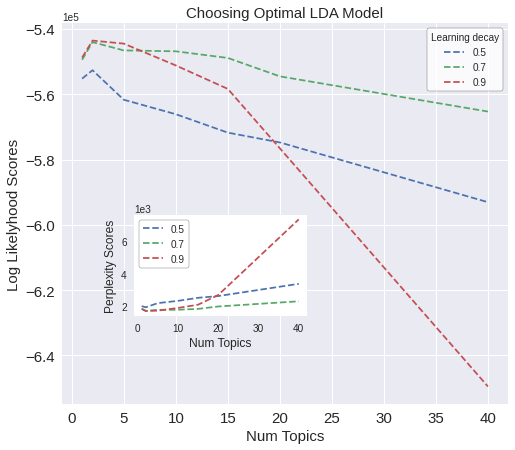

In [18]:
# vectorizer
vectorizer, vectors, feature_names = lda_preprocess(text_en, lang_en, n_features=n_features)

# lda gridsearch
lda_gridsearch(vectors, lang_en)


#### Topic modeling with the best LDA model

In [19]:
# best topic model

n_components = 5
learning_decay = 0.9

model = lda_topic_modeling(vectors, n_components, learning_decay, n_top_words)


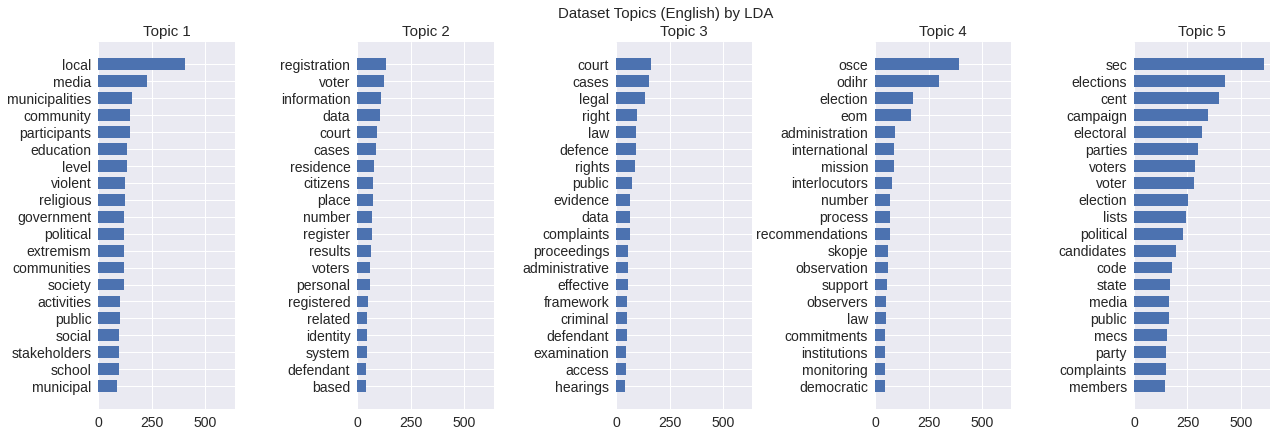

In [20]:
# topic words, document distribution, plot top 10 words in each topic

df_document_topics, df_topic_distribution, df_topic_keywords = major_topic_per_doc(model, vectors, 
                                                                                   vectorizer, text_en)

plot_top_words(model, feature_names, n_top_words, lang_en, 1, 5, (21, 6))
    
df_topic_keywords = show_topics(vectorizer, model, n_words=n_words)


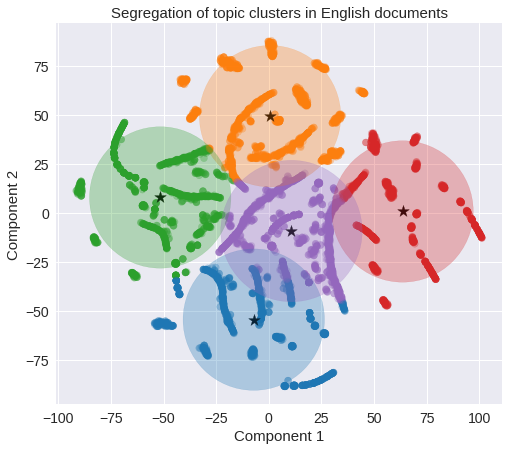

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
4      150.222153  -72.269554       1        1  34.851726
0       51.163364 -159.968018       2        1  27.901285
2      -73.144554   21.523815       3        1  13.442231
3      -66.410133 -110.606438       4        1  12.040432
1       54.417324   12.443444       5        1  11.764326, topic_info=              Term        Freq       Total Category  logprob  loglift
2681          osce  375.000000  375.000000  Default  30.0000  30.0000
2606         odihr  327.000000  327.000000  Default  29.0000  29.0000
2275         local  463.000000  463.000000  Default  28.0000  28.0000
1335      election  426.000000  426.000000  Default  27.0000  27.0000
606           cent  371.000000  371.000000  Default  26.0000  26.0000
...            ...         ...         ...      ...      ...      ...
3312       related   49.087226  169.040637   Topic5  -5.1645   0.9036
1833      hearings   38.465818   97.446658   Topic5  -5.4083   1.2106
3358        report   35.296581  101.015932   Topic5  -5.4943   1.0886
2043  institutions   35.974560  204.613580   Topic5  -5.4753   0.4018
2659         order   33.537047  146.210363   Topic5  -5.5454   0.6677

[349 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
0         1  0.958584     000
0         2  0.021302     000
101       1  0.050187  access
101       2  0.133832  access
101       3  0.802992  access
...     ...       ...     ...
4278      3  0.527495   years
4278      4  0.170660   years
4282      2  0.920198   young
4284      2  0.971006   youth
4284      4  0.021109   youth

[831 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 3, 4, 2])

In [21]:
# plot topic clusters

# kmeans
cluster_size = 20000
kmeans_topic_clustering(model, vectors, lang_en, n_clusters=n_components, cluster_size=cluster_size)

# pyldavis
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(model, vectors, vectorizer, mds='tsne')
panel